In [148]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
sns.set()

In [2]:
fields = 4
na_values=['nc',0]

# Lecture de l'onglet spécialistes sur le fichier xls
df_tarifs = pd.read_excel(open('honoraires_departement_en_2016.xls','rb'), sheet_name='Spécialistes', \
                          usecols=fields, na_values=na_values)

df_tarifs.head()

,Spécialistes,DEPARTEMENT,EFFECTIFS,HONORAIRES SANS DEPASSEMENT (Euros),DEPASSEMENTS (Euros)
0,02- Anesthésie-réanimation chirurgicale,01- Ain,17,4530079.33,2496180.45
1,02- Anesthésie-réanimation chirurgicale,02- Aisne,19,4985259.62,373837.57
2,02- Anesthésie-réanimation chirurgicale,03- Allier,19,5102901.70,560978.59
3,02- Anesthésie-réanimation chirurgicale,04- Alpes-Hte-Provence,4,NaN,NaN
4,02- Anesthésie-réanimation chirurgicale,05- Hautes-Alpes,5,NaN,NaN


### Peut-on établir un lien entre la densité de médecins par spécialité  et par territoire et la pratique du dépassement d'honoraires ?

<IPython.core.display.Javascript object>


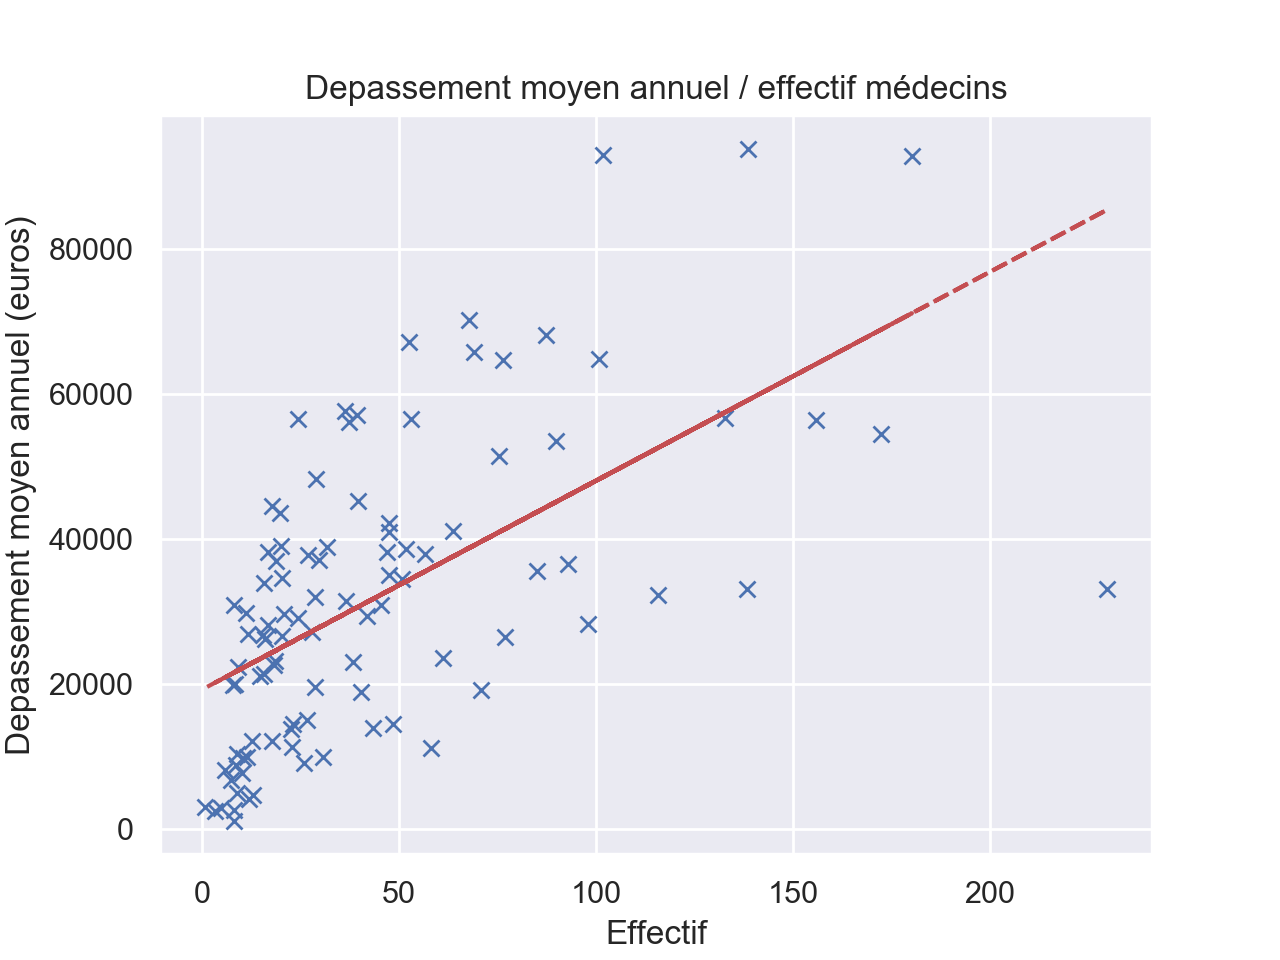

In [146]:
# Certaines effectifs sont nuls, par exemple '05- Hautes-Alpes'
df_tarifs[df_tarifs['DEPARTEMENT'] == '05- Hautes-Alpes']

# Moyenne des dépassements par effectifs -> 'Depassements moyens'
df_tarifs['Depassements moyens'] = df_tarifs['DEPASSEMENTS (Euros)'].where(df_tarifs['EFFECTIFS'] != 0)\
/ df_tarifs['EFFECTIFS'].where(df_tarifs['EFFECTIFS'] != 0)

# Condition multiple (inutilisée mais pour garder une trace)
#df_tarifs['DEPASSEMENTS (Euros)'].where((df_tarifs['EFFECTIFS'] != 0) | (df_tarifs['EFFECTIFS'] != 1))

# Groupement par département (perte d'info sur les spécialitées)
tarif_effectif = df_tarifs.groupby(['DEPARTEMENT'])['EFFECTIFS','Depassements moyens'].mean()

# Suppression points aberrants
tarif_effectif = tarif_effectif.drop('75- Paris (Ville)', axis=0)
tarif_effectif = tarif_effectif.filter(regex=('\d+-\s*\w+'), axis=0) # Filtre les TOTAL (dernières lignes)

x = tarif_effectif['EFFECTIFS']
y = tarif_effectif['Depassements moyens']
plt.figure()
plt.plot(x, y, 'x')

fit = np.polyfit(x, y ,1)
fit_fn = np.poly1d(fit)
plt.plot(x, fit_fn(x), '--r')
plt.xlabel('Effectif')
plt.ylabel('Depassement moyen annuel (euros)')
plt.title('Depassement moyen annuel / effectif médecins')

### Peut-on faire un lien entre population et dépassement d'honoraire ?

In [16]:
# Lecture table population par département / âge / genre
fields = None
df_population = pd.read_excel(open('estim-pop-dep-sexe-gca-1975-2018.xls','rb'), sheet_name='2018', \
                          usecols=fields, na_values=na_values, header=[0], skiprows=[0,1,2,3])

# Nouvelle colonne département avec sur le modèle de la table des tarifs des honoraires
df_population['Departement']=df_population['code Départements'].astype(str)+'- '+df_population['Départements'].astype(str) 

In [93]:
cols=['Departement','Total']
df_population[cols].head()

,Departement,Total
0,01- Ain,649654.0
1,02- Aisne,534286.0
2,03- Allier,338978.0
3,04- Alpes-de-Haute-Provence,161664.0
4,05- Hautes-Alpes,141576.0


In [139]:
# Changement du titre de l'index pour être homogène sur les 2 colonnes
tarif_effectif.index.name = 'Departement'

# Jointure sur la colonne departement
df_pop_tarif = df_population[cols].join(tarif_effectif, on='Departement')

df_pop_tarif2 = df_pop_tarif.dropna()
df_pop_tarif2.head()

,Departement,Total,EFFECTIFS,Depassements moyens
0,01- Ain,649654.0,24.245283,56579.135399
1,02- Aisne,534286.0,26.547170,15122.798200
2,03- Allier,338978.0,20.301887,26666.823041
4,05- Hautes-Alpes,141576.0,10.037736,7705.749534
5,06- Alpes-Maritimes,1080614.0,132.679245,56762.069669


<IPython.core.display.Javascript object>


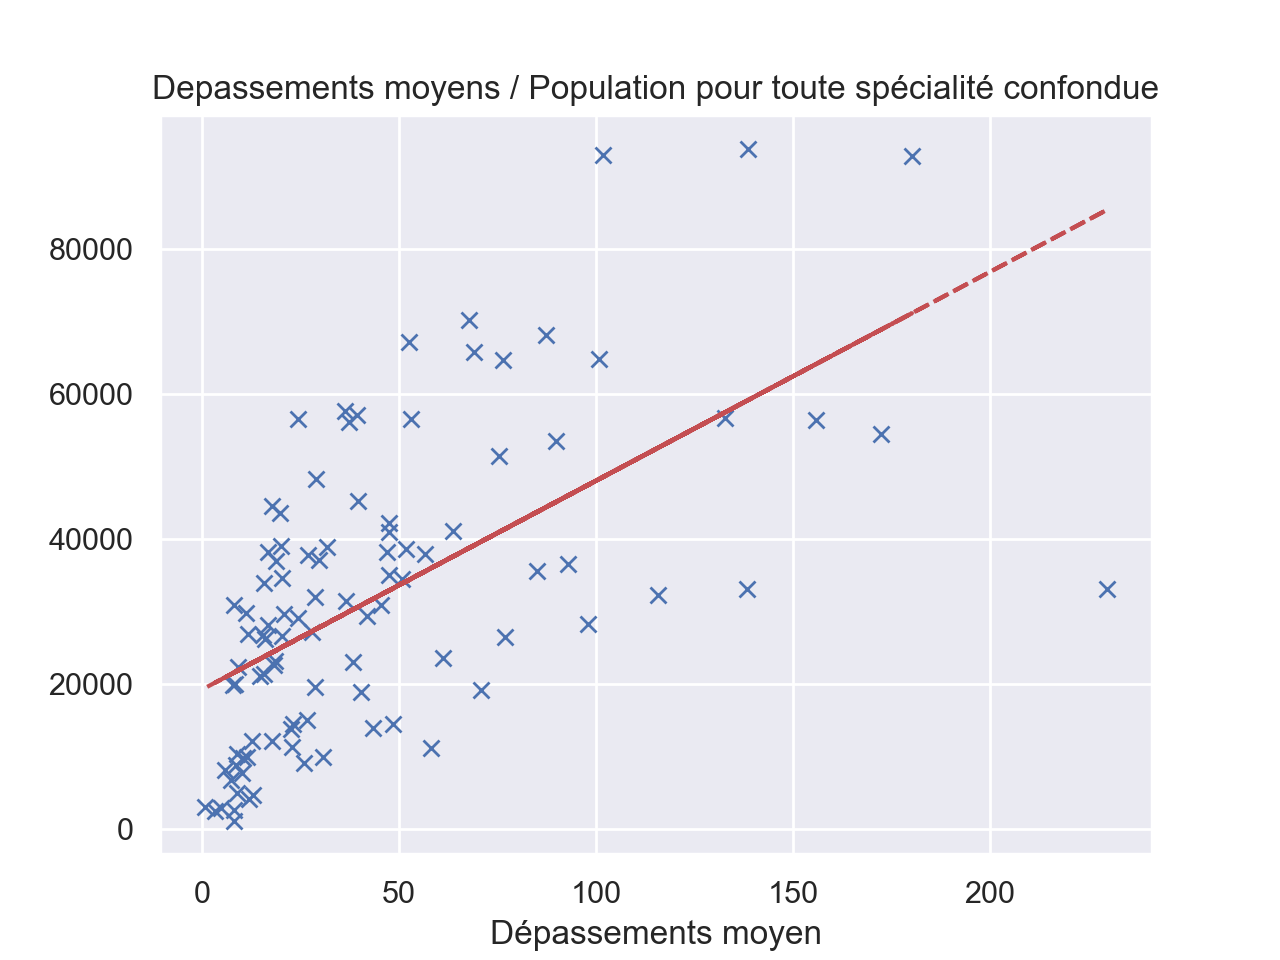

In [144]:
X = df_pop_tarif2['Total']
Y = df_pop_tarif2['Depassements moyens']

plt.figure()
plt.plot(x, y, 'x')
fit = np.polyfit(x, y ,1)
fit_fn = np.poly1d(fit)
plt.plot(x, fit_fn(x), '--r')
plt.title('Depassements moyens / Population pour toute spécialité confondue')
plt.xlabel('Population')
plt.xlabel('Dépassements moyen')

####  

### Peut-on faire un lien entre dépassement d'honoraire et spécialité ?
On se concentrera sur Paris pour cette question

In [157]:
# Tarif sur Paris uniquement
df_tarifs_paris = df_tarifs[df_tarifs['DEPARTEMENT'] == '75- Paris (Ville)'].dropna()
df_tarifs_paris.head(5)

<IPython.core.display.Javascript object>


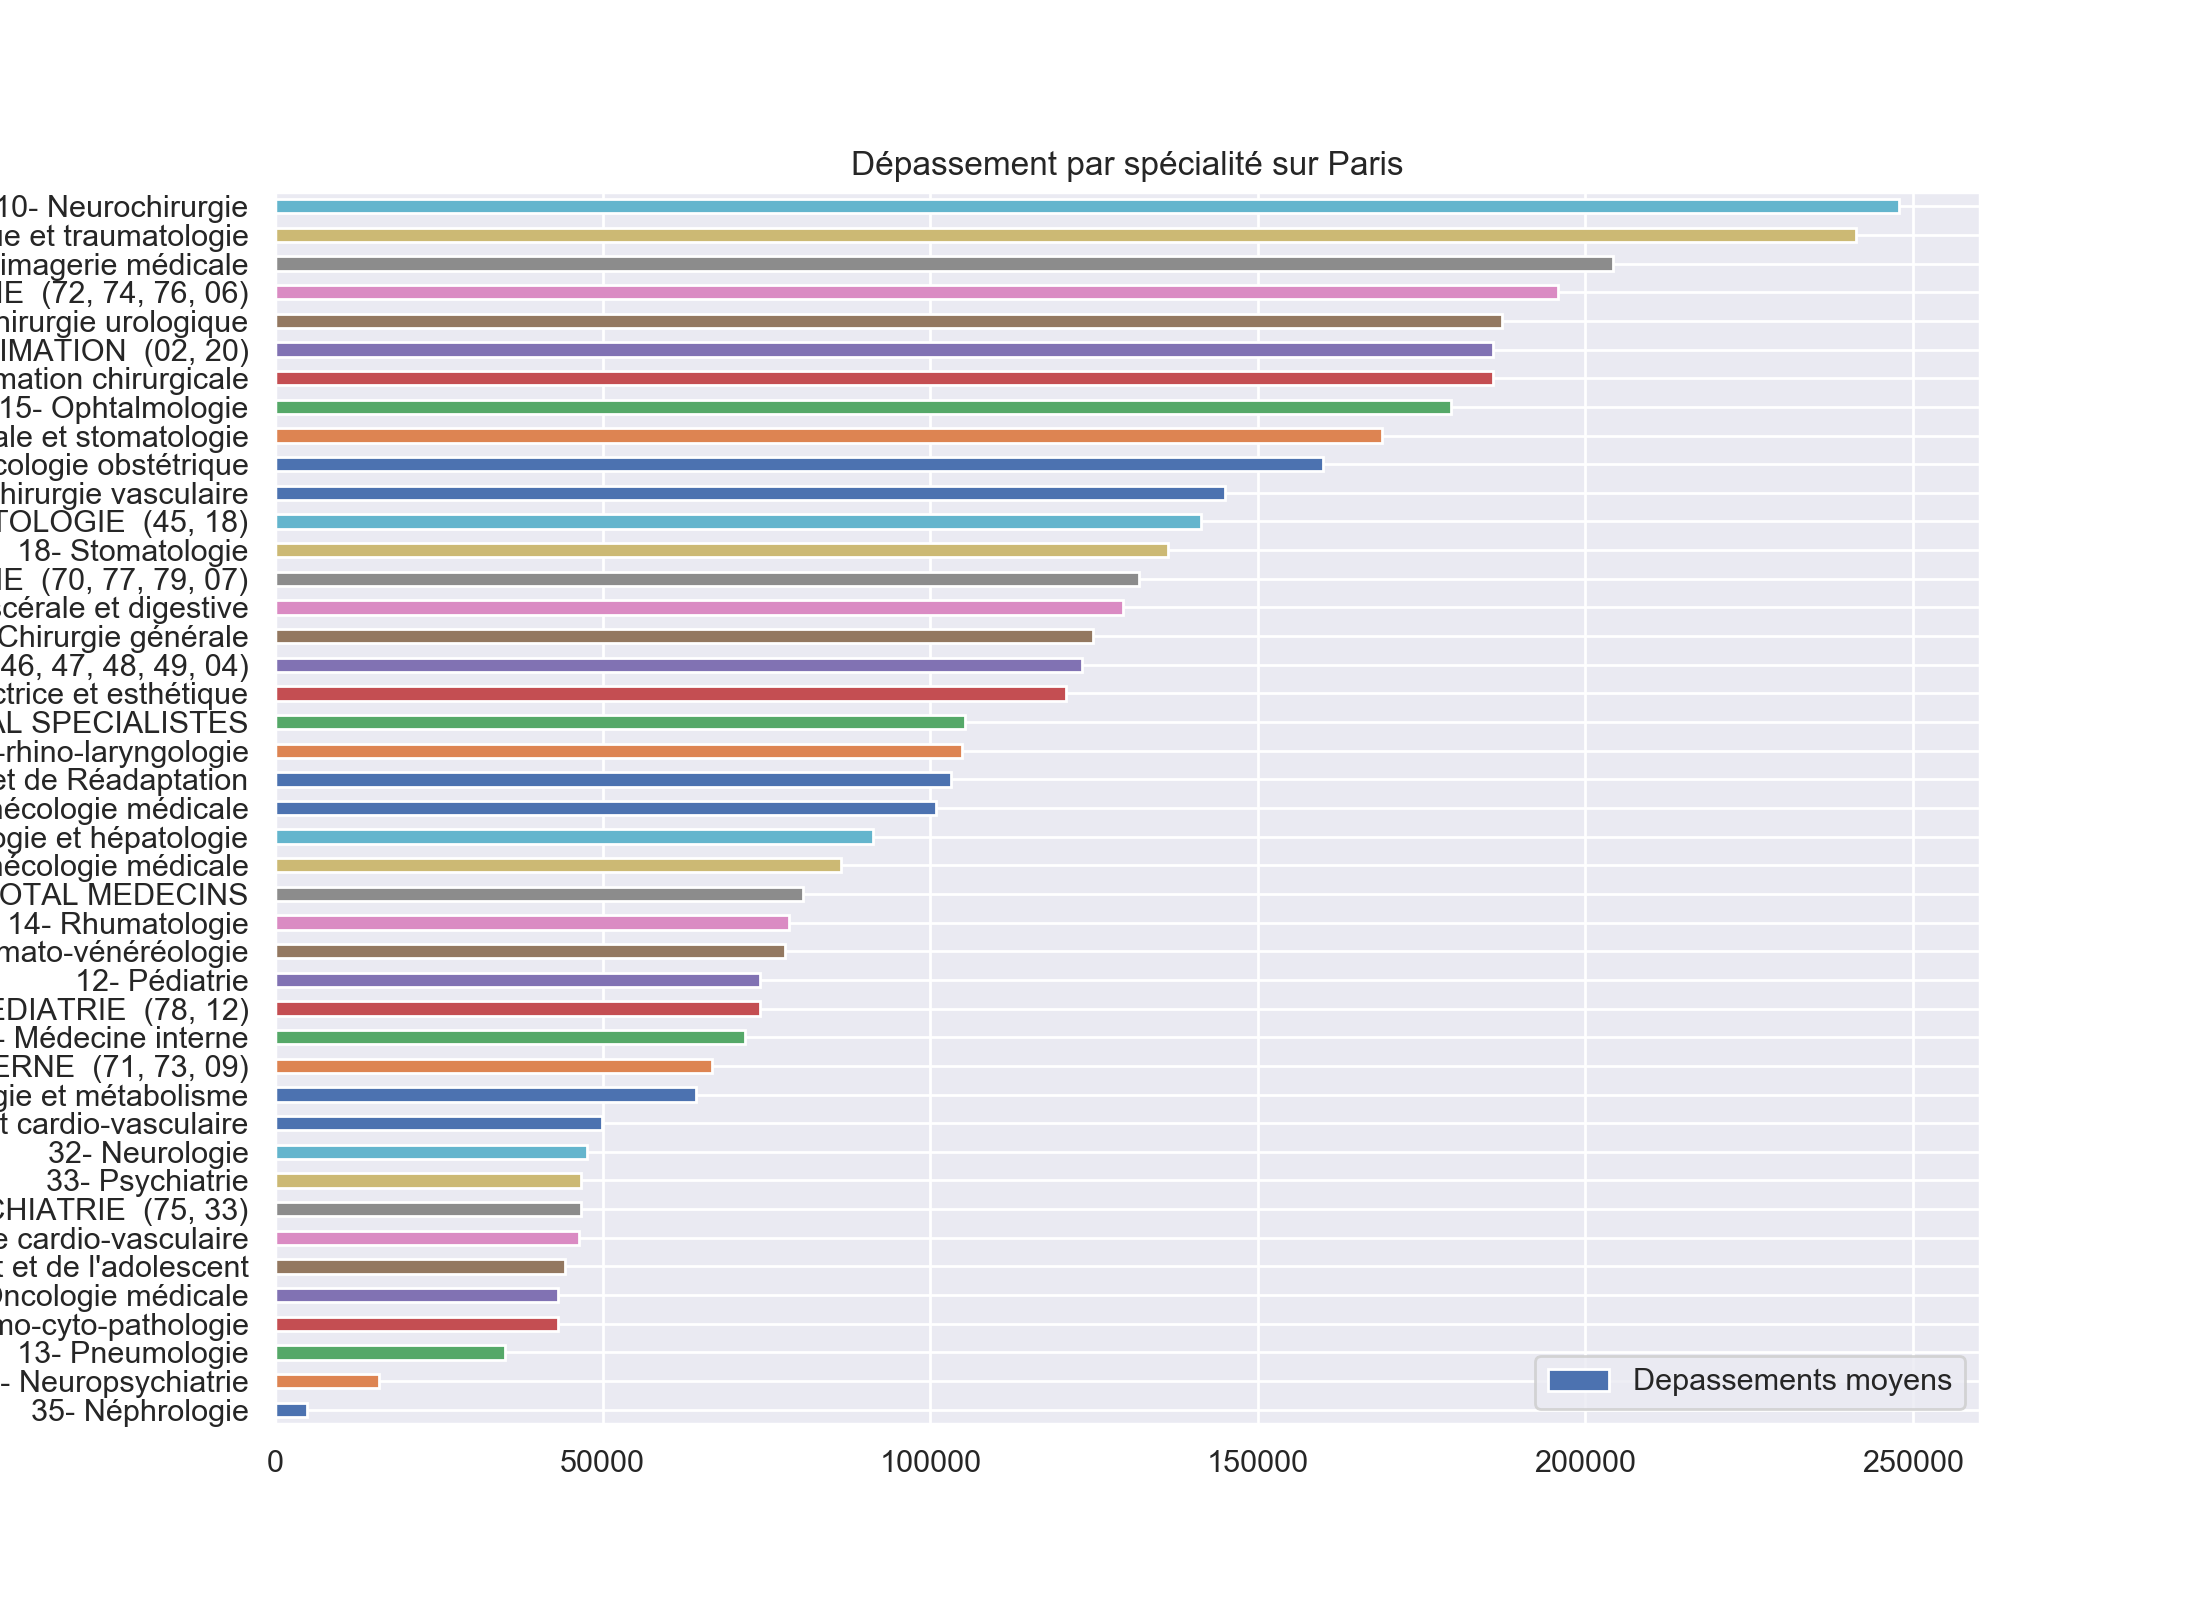

In [230]:
# Classe dépassement par spécialité
df_tarifs_paris2 = df_tarifs_paris[['Spécialistes', 'Depassements moyens']].sort_values(by='Depassements moyens')

# bar plot horizontale directement avec pandas
df_tarifs_paris2.plot(x = 'Spécialistes', y = 'Depassements moyens', kind='barh', figsize=(11,8))
plt.title('Dépassement par spécialité sur Paris')